Face Recognition using Principal Component Analysis

This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA) 
by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

#### Tasks
1. Load dataset and divide the date into training and test sets. 
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm

#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [2]:
# iterate through all folders, load each image

trainAmt = 0.9
allFaces = []
labels = []

for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join("ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

(360, 112, 92) (360,)


### Plotting the faces for a label

In [4]:
image_index = 30

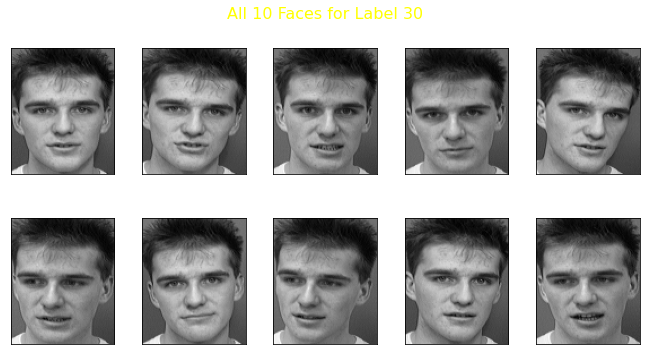

In [5]:
def plot_all_faces_for_label(images, labels, target_label, h, w):
    indices = np.where(labels == target_label)[0]

    # Plot all faces for the given label in a grid
    num_faces = len(indices)
    rows = (num_faces // 5) + 1  # Display in a grid with 5 columns
    cols = min(num_faces, 5)
    
    plt.figure(figsize=(1.8 * cols, 2.4 * rows))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[idx].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(f"Label: {labels[idx]}", size=10, color='white')
        plt.xticks(())
        plt.yticks(())

    plt.suptitle(f'All 10 Faces for Label {target_label}', size=16, color="yellow")
    plt.show()

# Visualizing all 10 faces for label 30
target_label_to_visualize = image_index
plot_all_faces_for_label(trainFaces, trainLabels, target_label_to_visualize, 112, 92)

#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

In [6]:
def my_pca(X):

    """
    Implement pca in the following function by taking the following arguements:
    1. X(images array)
    2. number of components
    The function must return the eigen vectors (principal components) also termed "Eigen faces"
    """

    mean_X = np.mean(X, axis=0) # mean across all features
    # centring the data
    centered_X = X - mean_X

    # covariance matrix for centered data
    cov_matrix = np.cov(centered_X, rowvar=False)

    # Calculate eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Sort eigenvalues and corresponding eigenvectors
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Select the top n_components eigenvectors
    # top_eigenvectors = eigenvectors[:, :n_components]
    # Project the data onto the new subspace
    # projected_data = np.dot(centered_X, top_eigenvectors)

    # return all eigenfaces
    return eigenvectors, eigenvalues, mean_X

### Calculating all eigenvectors and all eigenvalues at once

In [7]:
trainFaces_1d = trainFaces.reshape((trainFaces.shape[0], -1))
eig_vectors, eig_values, mean = my_pca(trainFaces_1d)

### Plotting eigenfaces

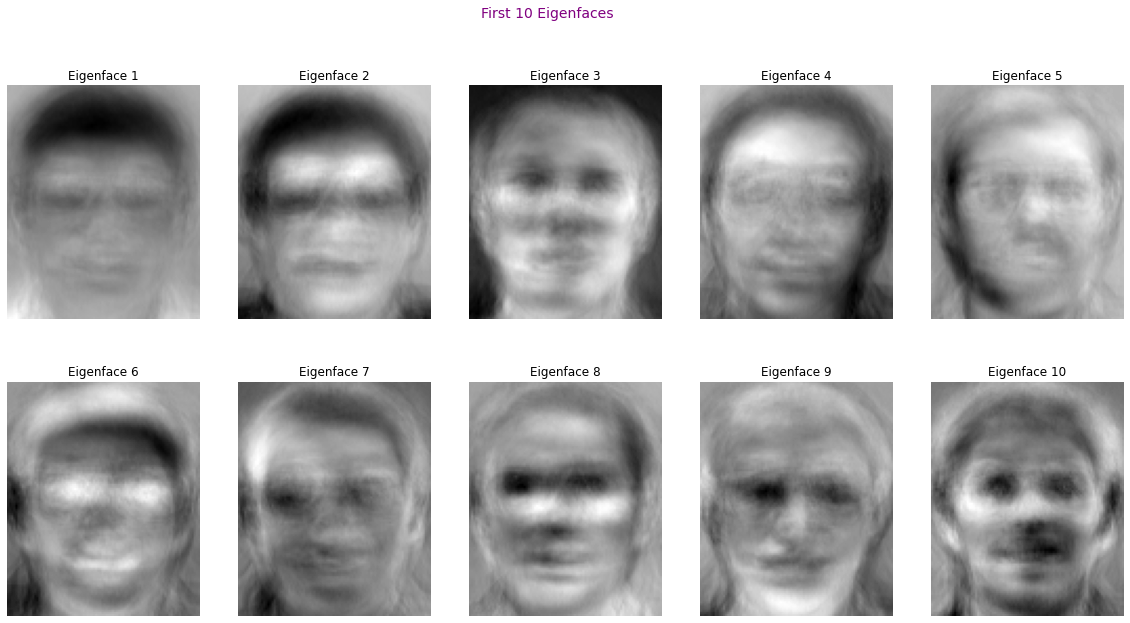

In [8]:
def plot_first_10_eigenfaces(eigenvectors, title="First 10 Eigenfaces"):
    num_components = min(10, eigenvectors.shape[1])  # Ensure not to exceed the number of components available

    plt.figure(figsize=(20, 10))
    plt.suptitle(title, color= "Purple", size=14)

    for i in range(num_components):
        if i < 5:
            plt.subplot(2, 5, i + 1)
            plt.imshow(eigenvectors[:, i].reshape(112, 92), cmap="gray")
            plt.title(f"Eigenface {i + 1}")
            plt.axis("off")
        else:
            plt.subplot(2, 5, i + 1)
            plt.imshow(eigenvectors[:, i].reshape(112, 92), cmap="gray")
            plt.title(f"Eigenface {i + 1}")
            plt.axis("off")

    plt.show()

plot_first_10_eigenfaces(eig_vectors, title="First 10 Eigenfaces")

#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

In [9]:
def imageReconstruction(testFace, eigenFaces, meanFace):

    """
    Helper function to reconstruct images
    """
    projected_test_face = np.dot((testFace.flatten() - meanFace), eigenFaces)

    # Reconstruct the test face using the eigen projections
    
    reconstructed_test_face = np.dot(projected_test_face, eigenFaces.T) + meanFace

    # Reshape the reconstructed test face to its original dimensions
    reconstructed_test_face = reconstructed_test_face.reshape(testFace.shape)
    return reconstructed_test_face

In [10]:
# plot recontructions here
%matplotlib inline

#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)

**Note:** Ensure that the images are labelled appropriately.

In [11]:
n_components = [5, 10, 50, 100]
reconstructed_faces_list = []

In [18]:
for n in n_components:
    # top_eigenvectors, mean_face, projected_train_faces = my_pca(trainFaces_1d, n)

    top_eigenfaces = eig_vectors[:, :n]

    # Example usage of imageReconstruction function
    reconstructed_faces = []
    for image_index in range(len(testFaces)):
        test_face = testFaces[image_index]
        reconstructed_test_face = imageReconstruction(test_face, top_eigenfaces, mean)
        reconstructed_faces.append(reconstructed_test_face)

    # Append reconstructed faces to the list
    reconstructed_faces_list.append(reconstructed_faces)

In [21]:
reconstructed_faces_array = np.array(reconstructed_faces_list)
print(reconstructed_faces_array.shape)

(8, 40, 112, 92)


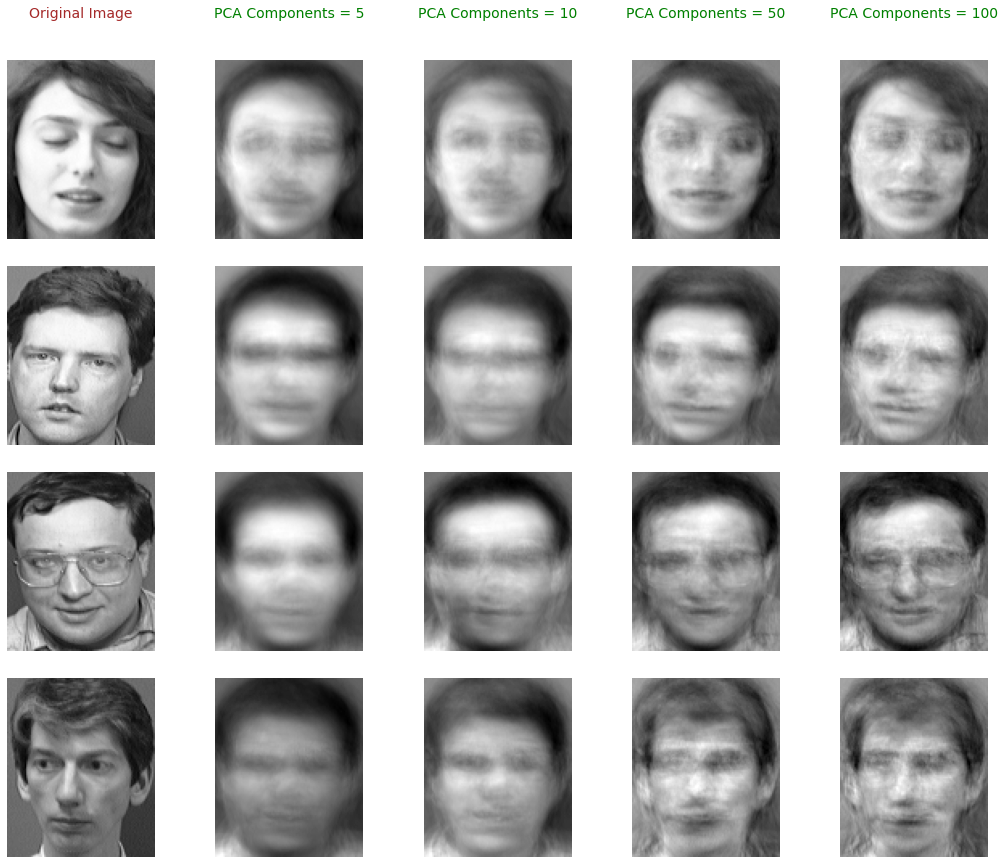

In [22]:
# Image Indices to visualize
indices_to_visualize = [1, 4, 9, 16]
num_components = 4

plt.figure(figsize=(15, 12))

# Original images
for i, index in enumerate(indices_to_visualize):
    plt.subplot(4, 5, i * 5 + 1)
    plt.imshow(testFaces[index], cmap="gray")
    plt.axis("off")

# Reconstructed images
for i, index in enumerate(indices_to_visualize):
    for j in range(num_components):
        plt.subplot(4, 5, i * 5 + j + 2)
        plt.imshow(reconstructed_faces_array[j, index, :, :], cmap="gray")
        plt.axis("off")
        plt.title(f"Using {n_components[j]} eigenvectors", size=12, color='white')


# to add title
        
for j in range(num_components + 1):
    plt.subplot(4, 5, j + 1)
    if j == 0:
        plt.title("Original Image", size=14, color='brown', y=1.2)
    else:
        plt.title(f"PCA Components = {n_components[j-1]}", size=14, color='green', y=1.2)

plt.tight_layout()
plt.show()

#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them. 
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations. 
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [66]:
def calculate_weights(image, eigenfaces, mean_face):
   
    flattened_image = image.flatten()
    centered_image = flattened_image - mean_face
    weights = np.dot(eigenfaces.T,centered_image)

    return weights

In [67]:
def calculate_weights(image, eigenfaces, mean_face):
   
    flattened_image = image.flatten()
    centered_image = flattened_image - mean_face
    weights = np.dot(eigenfaces.T,centered_image)

    return weights

# Predicts the class of the input test image based on the closest match found in the training set.

def getClass(testImage, eigenFaces, meanFace, trainFaces, trainLabels):
    """
    Arguments:
    1. testFace: Test image
    2. eigenFaces: Eigenvectors obtained from PCA
    3. meanFace: Mean Eigen Face
    4. X_train: Training Set (images array)
    5. y_train: Corresponding labels for the training set

    Returns:
    1. reconstructedFace: Image with the smallest error
    2. errorValue: Error value
    3. predictedClass: Prediction class
    """
    testWeight = calculate_weights(testImage,eigenFaces, meanFace)
    min_distance = float('inf')  # Initialize with infinity
    closestImage = None
    predictedClass = None

    for i in range(len(trainFaces)):
        trainImage = trainFaces[i]

        # calculate weights of eigenface for each train image
        trainWeight = calculate_weights(trainImage, eigenFaces, meanFace)
        distance = np.linalg.norm(testWeight - trainWeight)

        if distance < min_distance:
            min_distance = distance
            closestImage = trainImage
            predictedClass = trainLabels[i]

    errorValue = min_distance

    return closestImage, errorValue, predictedClass

Iterate through all the images in the test data and test the accuracy by taking different number of components

In [68]:
components = [3,5,10,20,30,40,50]
mse_arr = []

for numComponents in components:

    top_n_eigenfaces = eig_vectors[:, :numComponents]
    # print(top_n_eigenfaces.shape)

    mse_per_image = []

    for index in range(len(testFaces)):
        testImage = testFaces[index]
        closestImage, error_value, predictedClass = getClass(test_face, top_n_eigenfaces, mean, trainFaces, trainLabels)
        
        mse_per_image.append(error_value)
    
    mean_mse = np.mean(mse_per_image)
    
    # Store the mean MSE in the mse_arr
    mse_arr.append(mean_mse)

Plot Number of eigenvectors vs Mean Square Error

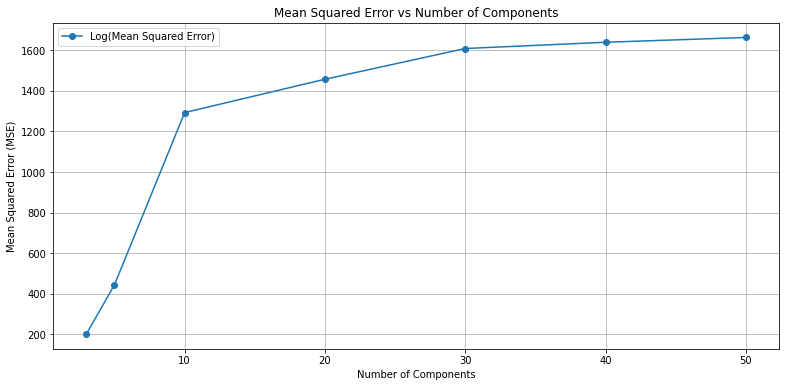

In [64]:
plt.figure(figsize=(13,6))

plt.plot(components, mse_arr, marker='o', label='Log(Mean Squared Error)')
plt.xlabel('Number of Components')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean Squared Error vs Number of Components')
plt.legend()
plt.grid(True)
plt.show()

Plot Number of eigenvectors vs Logarithmic Mean Square Error

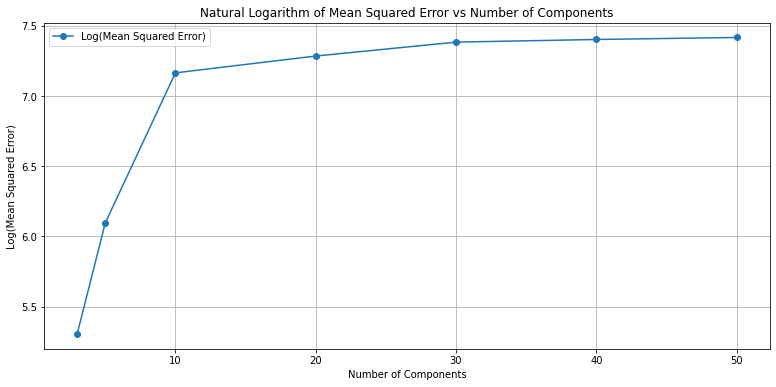

In [65]:
plt.figure(figsize=(13,6))

plt.plot(components, np.log(mse_arr), marker='o', label='Log(Mean Squared Error)')
plt.xlabel('Number of Components')
plt.ylabel('Log(Mean Squared Error)')
plt.title('Natural Logarithm of Mean Squared Error vs Number of Components')
plt.legend()
plt.grid(True)
plt.show()

### **Observation**

1. **Bias-Variance Trade-off**:

In the context of dimensionality reduction with PCA, reducing the number of components (eigenvectors) decreases the model's ability to capture the complexity of the data, leading to higher bias.
On the other hand, increasing the number of components allows the model to capture more variability in the data, potentially reducing bias but increasing variance.
As you increase the number of components beyond a certain point, the model starts to capture more noise and specificities in the training data, leading to overfitting and higher variance.

2. **Overfitting**:

When the number of components increases, the model becomes more complex and has a higher capacity to fit the training data more closely.
However, this increased complexity can lead to overfitting, where the model learns to memorize the training data rather than capturing its underlying patterns.
As a result, the model may perform well on the training data but generalize poorly to unseen data, leading to higher MSE.

3. **Loss of Generalization**:

With higher numbers of components, the model may become more specialized in representing the training data, losing its ability to generalize to unseen data.
This loss of generalization can result in higher errors when evaluating the model on test or validation data, leading to higher MSE values.

4. **Dimensionality Increase**:

Increasing the number of components effectively increases the dimensionality of the feature space.
In high-dimensional spaces, the data points tend to become more spread out, making it harder to find meaningful patterns and relationships.
This increased sparsity and complexity can lead to higher errors when reconstructing the data, contributing to higher MSE values.